In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage import color
import gc
import datetime

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Utility functions for color conversion

def rgb2lab(img):
    # img - image tensor
    img_original = img.numpy().transpose((1, 2, 0))
    img_lab = color.rgb2lab(img_original)
    img_lab = (img_lab + 128) / 255
    img_ab = img_lab[:, :, 1:3]
    img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
    img_l = img_lab[:, :, 0]
    img_l = torch.from_numpy(img_l).float().unsqueeze(0)
    img_gray = color.rgb2gray(img_original)
    img_gray = torch.from_numpy(img_gray).unsqueeze(0).float()
    return img_gray, img_ab, img_l

def lab2rgb(l, a, b):
    # l, a, b - image tensors representing LAB channels
    img_lab = torch.stack([l, a, b])
    img_lab = img_lab * 255 - 128
    img_rgb = color.lab2rgb(img_lab.cpu().detach().numpy().transpose((1, 2, 0)))
    img_rgb = torch.from_numpy(img_rgb.transpose((2, 0, 1))).float()
    return img_rgb

# download and split data into train and test sets
def get_datasets(dataset_path):
    dataset = torchvision.datasets.ImageFolder(dataset_path, transform=T.Compose([
        T.Resize((256, 256)),
        T.ToTensor()
    ]))

    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    return torch.utils.data.random_split(dataset, [train_size, test_size])

**Define models**

In [3]:
# global feature extractor based on Resnet
class ExtractorResnet(nn.Module):
    def __init__(self, base_model):
        super(ExtractorResnet, self).__init__()
        base_model.conv1.weight = nn.Parameter(base_model.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(
            *list(base_model.children())[0:6]
        )

    def forward(self, x):
        x = self.encoder(x)
        return x

# global feature extractor based on EfficientNet
class ExtractorEfficientNet(nn.Module):
    def __init__(self, base_model):
        super(ExtractorEfficientNet, self).__init__()
        base_model.features[0][0].weight = nn.Parameter(base_model.features[0][0].weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(base_model.children())[0][0:4])

    def forward(self, x):
        x = self.encoder(x)
        return x

# auto encoder decoder based on Resnet
class ColorNetResnet(nn.Module):

    def __init__(self, base_model, global_output_size=0):
        super(ColorNetResnet, self).__init__()
        self.global_output_size = global_output_size
        base_model.conv1.weight = nn.Parameter(base_model.conv1.weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(base_model.children())[0:6])
        encoder_output_size = self.encoder(torch.zeros((1, 1, 256, 256))).shape[1]
        self.decoder = nn.Sequential(     
            nn.Conv2d(global_output_size + encoder_output_size, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.global_output_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

# auto encoder decoder based on EfficientNet
class ColorNetEfficientNet(nn.Module):

    def __init__(self, base_model, global_output_size=0):
        super(ColorNetEfficientNet, self).__init__()
        self.global_output_size = global_output_size
        base_model.features[0][0].weight = nn.Parameter(base_model.features[0][0].weight.sum(dim=1).unsqueeze(1))
        self.encoder = nn.Sequential(*list(base_model.children())[0][0:4])
        encoder_output_size = self.encoder(torch.zeros((1, 1, 256, 256))).shape[1]
        self.decoder = nn.Sequential(     
            nn.Conv2d(global_output_size + encoder_output_size, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=2)
        )

    def forward(self, x, in_=None):
        x = self.encoder(x)
        if self.global_output_size > 0:
            x = torch.cat([x, in_], dim=1)
        x = self.decoder(x)
        return x

**Initialize the model**

In [4]:
base_models = {
    "resnet18": torchvision.models.resnet18,
    "resnet50": torchvision.models.resnet50,
    "resnet152": torchvision.models.resnet152,
    "efficientnet_b0": torchvision.models.efficientnet_b0,
    "efficientnet_b1": torchvision.models.efficientnet_b1
}
model_name = "efficientnet_b0"
extractor = ExtractorEfficientNet(base_model=base_models["efficientnet_b1"]())
model = ColorNetEfficientNet(base_model=base_models[model_name](), global_output_size=extractor(torch.zeros((1, 1, 256, 256))).shape[1])
model.load_state_dict(torch.load('models/efficientnet_b0_2022-05-25_11:10:27:326809.pth'))
extractor.to(device)
model.to(device)

ColorNetEfficientNet(
  (encoder): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): ConvNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): ConvNormActiva

**Download the dataset**

In [6]:
lhq256_train, lhq256_test = get_datasets("LHQ256")

**Train the model**

In [8]:
time = str(datetime.datetime.now()).replace('.', ':').replace(' ', '_')
checkpoint_path = f'models/{model_name}_{time}.pth'
convert_fn = rgb2lab
revert_fn = lab2rgb

def train(model, extractor, train_dataset, test_dataset, plot_name, checkpoint_path, convert_fn=rgb2lab, eval_interval=20, batch_size=16, epochs=2000, lr=0.01, decay=1e-10):
  train_losses = []
  val_losses = []
  iterations = []
  criterion = nn.MSELoss().to(device)
  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=decay)
  min_loss = float('inf')
  with tqdm(range(epochs)) as eps:
    for e in eps:
      # sample images from the train set
      batch_idx = random.choices(np.arange(len(train_dataset)), k=batch_size)
      train_images = [convert_fn(train_dataset[n][0]) for n in batch_idx]
      gray_inputs = torch.stack([im[0] for im in train_images]).to(device)
      color_inputs = torch.stack([im[1] for im in train_images]).to(device)
      
      # backpropagate and step
      optimizer.zero_grad()
      global_features = extractor(gray_inputs).to(device)
      color_outputs = model(gray_inputs, global_features).to(device)
      loss = criterion(color_outputs, color_inputs)
      loss.backward()
      optimizer.step()
      train_loss = loss.item()
      
      eps.set_postfix(train_loss=train_loss, min_val_loss=min_loss)

      if (e % eval_interval == 0 and e != 0):
        train_losses.append(train_loss)
        iterations.append(e)

        # save the model
        torch.save(model.state_dict(), checkpoint_path)

        # evaluate the model on the test set
        batch_idx = random.choices(np.arange(len(test_dataset)), k=batch_size)
        val_images = [convert_fn(test_dataset[n][0]) for n in batch_idx]
        gray_inputs = torch.stack([im[0] for im in val_images]).to(device)
        color_inputs = torch.stack([im[1] for im in val_images]).to(device)
        with torch.no_grad():
          global_features = extractor(gray_inputs).to(device)
          color_outputs = model(gray_inputs, global_features).to(device)
          val_loss = criterion(color_outputs, color_inputs)
          val_losses.append(val_loss.item())
          if (val_loss.item() < min_loss):
            min_loss = val_loss.item()

        # plot losses
        plt.figure()
        plt.plot(iterations, train_losses, label='train loss')
        plt.plot(iterations, val_losses, label='val loss')
        plt.yscale('log')
        plt.xlabel("iterations")
        plt.ylabel("loss")
        plt.legend()
        plt.savefig(plot_name)
        plt.close('all')

In [ ]:
train(model, extractor, lhq256_train, lhq256_test, eval_interval=40, epochs=4000, plot_name=f"plots/{model_name}_{time}.png", checkpoint_path=f'models/{model_name}_{time}.pth')

**Try predict colors**

/homes/iws/lpremc/miniconda3/envs/cse455/lib/python3.9/site-packages/skimage/_shared/utils.py:394: UserWarning: Color data out of range: Z < 0 in 2335 pixels
  return func(*args, **kwargs)


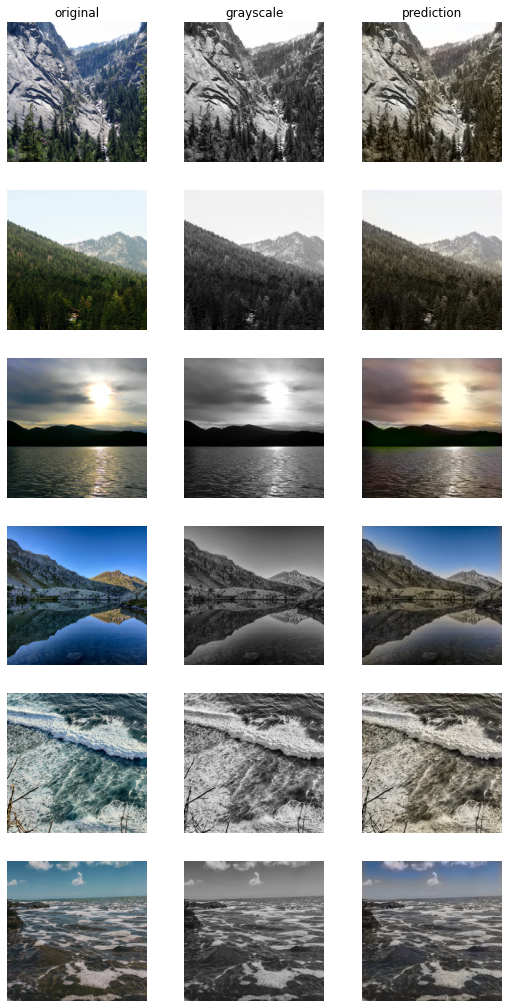

In [42]:
# try predict colors
pil_image = T.ToPILImage()
dataset = lhq256_test
batch_idx = random.choices(range(len(dataset)), k=6)
test_images = [convert_fn(dataset[n][0]) for n in batch_idx]
gray_inputs = torch.stack([im[0] for im in test_images]).to(device)
color_inputs = torch.stack([im[1] for im in test_images]).to(device)
l_inputs = torch.stack([im[2] for im in test_images]).to(device)
with torch.no_grad():
    global_features = extractor(gray_inputs)
    color_outputs = model(gray_inputs, global_features)
rgb_inputs = torch.stack([dataset[n][0] for n in batch_idx])
rgb_outputs = torch.stack([revert_fn(l_inputs[i][0], color_outputs[i][0], color_outputs[i][1]) for i in range(len(color_outputs))])
fig, axs = plt.subplots(6, 3)
fig.set_size_inches(9, 18)
nrows = int(len(rgb_outputs))
ncols = 3
for i in range(nrows):
    if (i == 0):
        axs[i, 0].set_title("original")
        axs[i, 1].set_title("grayscale")
        axs[i, 2].set_title("prediction")
    axs[i, 0].imshow(pil_image(rgb_inputs[i]))
    axs[i, 0].axis("off")
    axs[i, 0].axis("tight")
    axs[i, 0].axis("image")
    axs[i, 1].imshow(pil_image(gray_inputs[i]), cmap='gray', vmin=0, vmax=255)
    axs[i, 1].axis("off")
    axs[i, 1].axis("tight")
    axs[i, 1].axis("image")
    axs[i, 2].imshow(pil_image(rgb_outputs[i]))
    axs[i, 2].axis("off")
    axs[i, 2].axis("tight")
    axs[i, 2].axis("image")
fig.savefig(f"results/efficientnet_b0_2022-05-25_11:10:27:326809_result4.png")

# clear memory
del gray_inputs
del color_inputs
del global_features
del color_outputs
del l_inputs
gc.collect()
torch.cuda.empty_cache()